In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy
from scipy.signal import butter, lfilter, freqz
from math import atan2, degrees, isnan, sqrt


from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Functions for reading gaze data

In [2]:
df=pd.read_csv('/content/drive/MyDrive/Eye Tracking/train.csv', error_bad_lines=False)

b'Skipping line 81: expected 17488 fields, saw 26864\n'
b'Skipping line 152: expected 17488 fields, saw 33138\nSkipping line 160: expected 17488 fields, saw 20410\n'
b'Skipping line 472: expected 17488 fields, saw 23290\n'
b'Skipping line 548: expected 17488 fields, saw 28096\n'
b'Skipping line 571: expected 17488 fields, saw 44026\n'
b'Skipping line 600: expected 17488 fields, saw 22990\n'
b'Skipping line 622: expected 17488 fields, saw 17680\n'
b'Skipping line 651: expected 17488 fields, saw 31846\n'
b'Skipping line 688: expected 17488 fields, saw 21864\n'
b'Skipping line 728: expected 17488 fields, saw 21032\n'
b'Skipping line 760: expected 17488 fields, saw 20060\n'
b'Skipping line 842: expected 17488 fields, saw 18164\n'


In [8]:
def get_data(subject_id, index):
  data = df[df.iloc[:, 0] == subject_id].to_numpy()
  # print(df[df.iloc[:, 0] == subject_id].to_numpy().shape)
  sid = numpy.delete(data[index, :], [0, 1])
  # print(sid)

  x = numpy.array(sid[::2], dtype=float)
  y = numpy.array(sid[1::2], dtype=float)
  # print(x.shape)
  # print(y.shape)

  plt.rcParams['figure.dpi'] = 200
  plt.scatter(x, y, s=0.5)
  plt.xticks(range(-700, 800, 100))
  plt.yticks(range(-700, 800, 100))
  plt.title('Gaze Data: '+subject_id)
  plt.tick_params(axis='both', which='major', labelsize=5)
  plt.xlabel('x-axis')
  plt.ylabel('y-axis')
  plt.show()

  plt.plot(x[0:5000], "r", label='x-position')
  plt.plot(y[0:5000], "b", label='y-position')
  plt.ylabel('Relative Position')
  plt.legend(fontsize='xx-small', loc='upper right')
  plt.show()
  return x[~numpy.isnan(x)], y[~numpy.isnan(y)]

# Fixation Detection Algorithm Implementation

In [15]:
#Utility Functions
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Function for Converting visual angle to pixel
def angle2pix(x):
  deg_per_px = degrees(atan2(.5*height, distance)) / (.5*res_height)
  return x / deg_per_px

# Function for Get sign of number - 0 if -ve and 1 if +ve
def sign(x): 
  return 1-(x<=0)


In [23]:
# Fixation detection Function
def Fixation_Detection(x , y, vel_filter, sac_min, sac_max, fix_max, filter):
  N = x.shape[0]
  K = len(vel_filter)

  # Calculating Velocity
  velocity   = [0 for i in range (N-K-1)]
  velocity_x = [0 for i in range (N-K-1)]
  velocity_y = [0 for i in range (N-K-1)]

  for i in range (N-K-1):
    for j in range (K):
        velocity_x[i] = velocity_x[i] + (x[i+j]*vel_filter[j])
        velocity_y[i] = velocity_y[i] + (y[i+j]*vel_filter[j])

  for i in range (N-K-1):
    velocity[i]   = ((velocity_x[i] ** 2 + velocity_y[i] ** 2))**0.5
    if(isnan(velocity[i])):
      velocity[i] = 0

  if filter:
    vel = butter_lowpass_filter(velocity, cutoff=1.2, fs=30, order=5)
  else:
    vel = velocity

  print("sac min: ", sac_min, "\nSac max: ", sac_max, "\nFix max: ", fix_max)

  # detection of fixation and saccades
  fixation_index = []
  saccades_index = []
  fixation_group = []
  saccades_group = []

  for i in range (N-K-1):
    # Saccade detected
    if(velocity[i] >= sac_min and velocity[i] <= sac_max):
      if(fixation_group):
        fixation_index.append(fixation_group)
        fixation_group = []
      saccades_group.append(i)

    # Fixation detected
    elif(velocity[i] <= fix_max):       
      if(saccades_group):
        saccades_index.append(saccades_group)
        saccades_group = []
      fixation_group.append(i)

  if(fixation_group):
    fixation_index.append(fixation_group)
  if(saccades_group):
    saccades_index.append(saccades_group)

  return fixation_index, saccades_index, vel

# Get centroid of each fixation groups
def get_centroid(x, y, fixations_index):
  centroid_x = []
  centroid_y = []
  for group in fixations_index:
    print(group)
    centroid_x.append(sum([x[i] for i in group])/len(group))
    centroid_y.append(sum([y[i] for i in group])/len(group))
  return centroid_x, centroid_y


# Main Code

In [6]:
# Parameters Settings
sampling_rate = 1000      # 1/T = 1000Hz

# Velocity FIR filter (two-tap filter)
Filter        = [1, -1]   
vel_FIR       = [i*sampling_rate for i in Filter]

# Setup
distance      = 450       # mm
height        = 113       # mm
res_height    = 1400

# Fixation and Saccade Threshold
sac_min_thres = 130       # degree
sac_max_thres = 750       # degree
fix_max_thres = 50        # degree

(34, 17488)


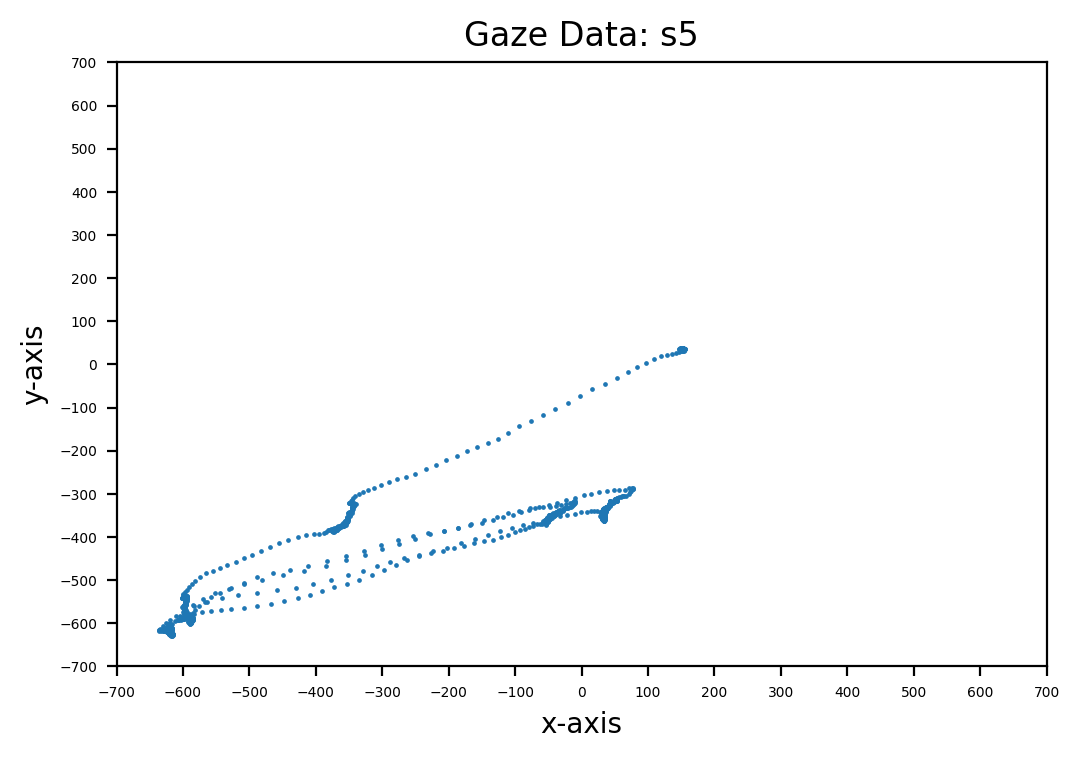

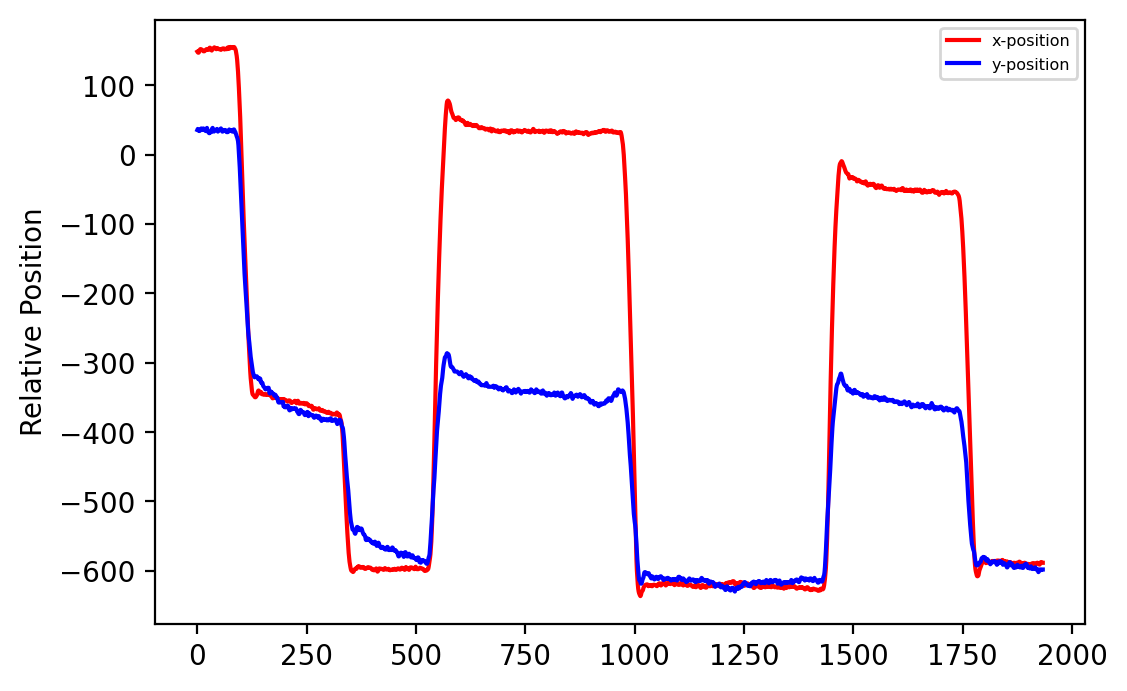

In [9]:
[x, y] = get_data('s5', 3)  # Get 4th dataset of subject_id = s5

sac min:  12715.969770236614 
Sac max:  73361.36405905739 
Fix max:  4890.757603937159
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
[126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 2

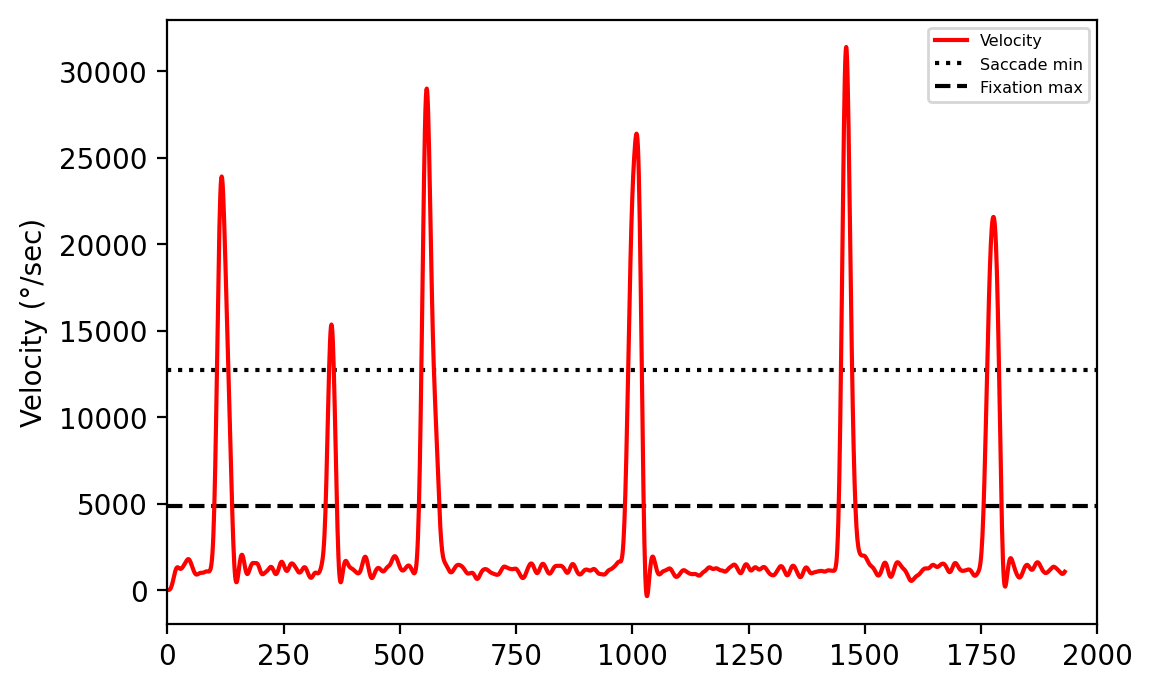

[152.16522222222224, -358.5721182266011, -597.11217877095, 36.526815920398, -621.7815366430269, -46.38592727272728, -589.3042105263156]
[34.93200000000001, -362.24995073891665, -566.4578770949719, -339.10597014925395, -615.3042316784883, -354.7477818181816, -591.0775657894733]


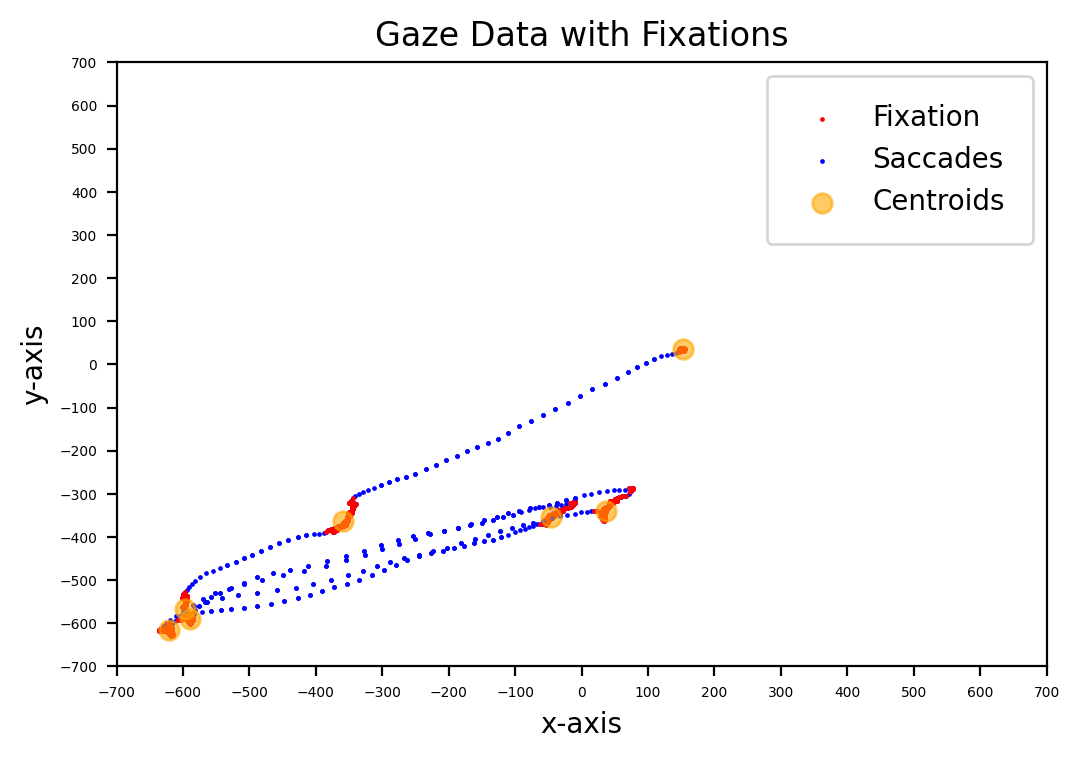

In [25]:
# detection of fixations in gaze dataset
[fixation_index, saccades_index, velocity] = Fixation_Detection(x , y, vel_FIR, 
                                                                angle2pix(sac_min_thres), 
                                                                angle2pix(sac_max_thres) , 
                                                                angle2pix(fix_max_thres),
                                                                filter=True)


[centroid_x, centroid_y] = get_centroid(x, y, fixation_index)

# plotting velocity against gaze sample
plt.rcParams['figure.dpi'] = 200

plt.plot(velocity, "r", label='Velocity')
plt.xlim(0, 2000)
plt.hlines(angle2pix(sac_min_thres), 0, 2000, colors='k', linestyles='dotted', label='Saccade min')
plt.hlines(angle2pix(fix_max_thres), 0, 2000, colors='k', linestyles='dashed', label='Fixation max')
plt.legend(fontsize='xx-small', loc='upper right')
plt.ylabel('Velocity (°/sec)')
plt.show()

# Plot gaze data with detected fixations in red and saccades in blue
plt.scatter(x, y, s=0.5, color='blue')

fixation = [index for sublist in fixation_index for index in sublist]
fix_x = x[fixation]
fix_y = y[fixation]
plt.scatter(fix_x, fix_y, s=0.5, color='red', label="Fixation")

saccades = [index for sublist in saccades_index for index in sublist]
sac_x = x[saccades]
sac_y = y[saccades]
plt.scatter(sac_x, sac_y, s=0.5, color='blue', label="Saccades")

plt.scatter(centroid_x, centroid_y, s=50, alpha=0.6, color='orange', label="Centroids")
print(centroid_x)
print(centroid_y)

plt.legend(borderpad=1)
plt.xticks(range(-700, 800, 100))
plt.yticks(range(-700, 800, 100))
plt.title("Gaze Data with Fixations")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

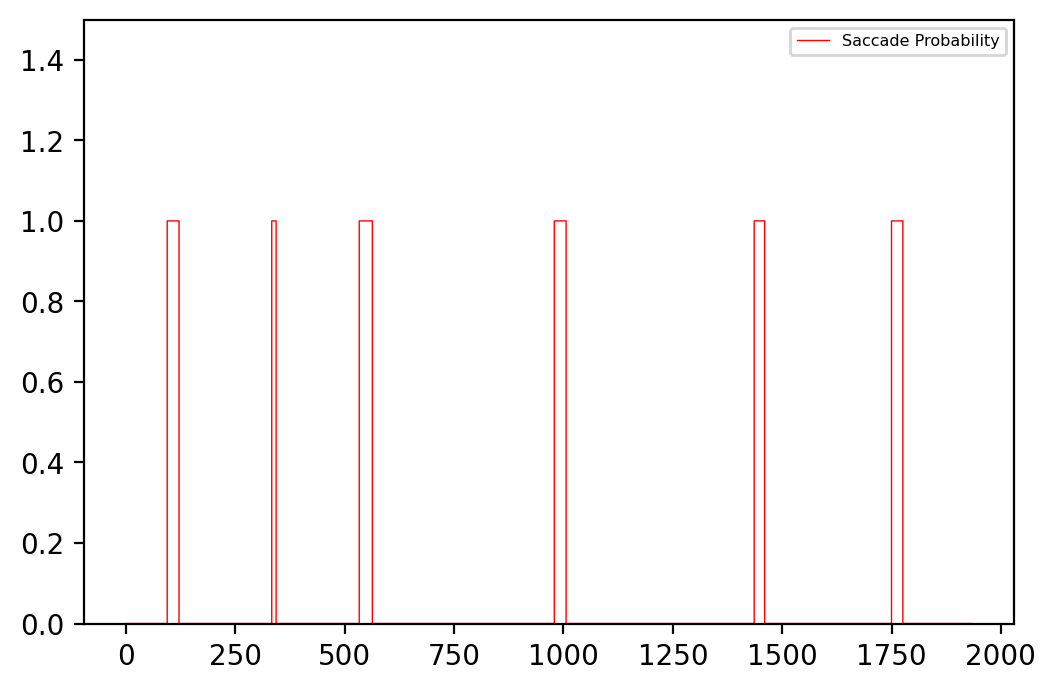

[90.0, 203.0, 179.0, 402.0, 423.0, 275.0, 152.0]
Average fixation duration is:  246.28571428571428


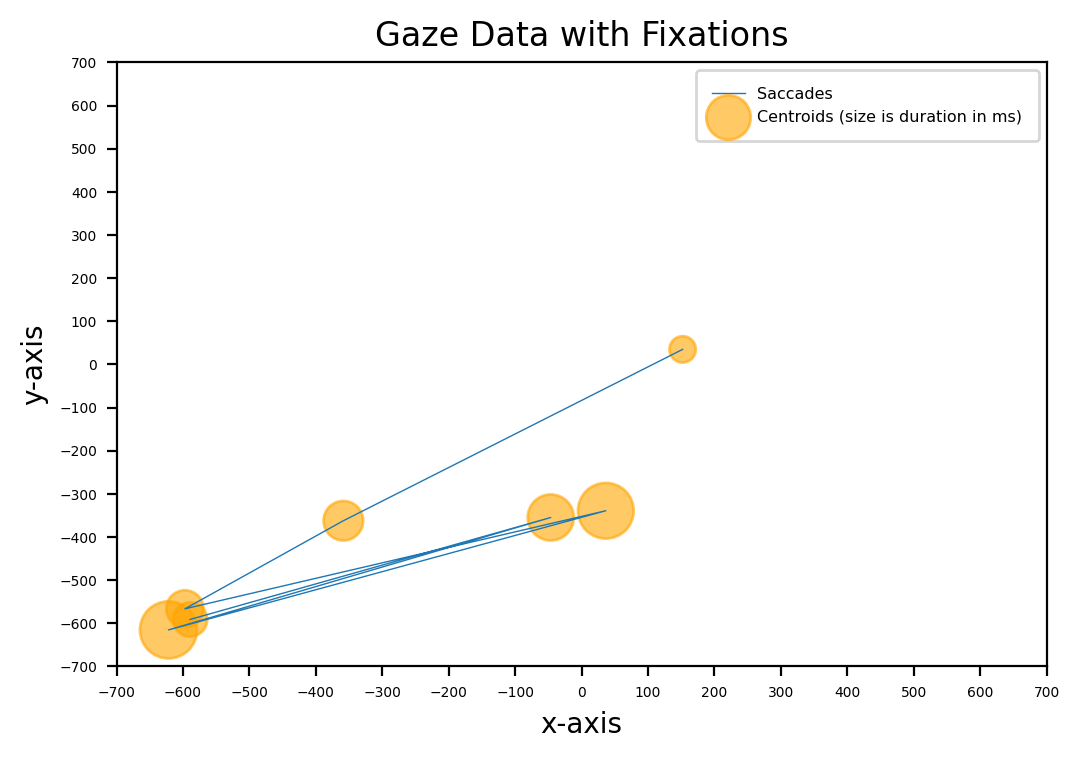

In [14]:
is_saccades = []
for i in range(len(x)):
  if i in saccades:
    is_saccades.append(True)
  else:
    is_saccades.append(False)

plt.ylim(0, 1.5)
plt.step(is_saccades[0:5000], 'r', linewidth = 0.5, where='post', label="Saccade Probability")
plt.legend(fontsize='xx-small', loc='upper right')
plt.show()

# Calculating Duration 
duration = []
for fixation in fixation_index:
  duration.append((len(fixation)/sampling_rate) * 1000) # duration in ms

print(duration)

print("Average fixation duration is: ", numpy.mean(duration))
plt.plot(centroid_x, centroid_y, linewidth = 0.5, label="Saccades")
plt.scatter(centroid_x, centroid_y, s=duration, alpha=0.6, color='orange', label="Centroids (size is duration in ms)")

plt.legend(borderpad=1, fontsize='xx-small')
plt.xticks(range(-700, 800, 100))
plt.yticks(range(-700, 800, 100))
plt.title("Gaze Data with Fixations")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()